## Load In Imports

In [1]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
import struct
import time
import numpy as np
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from glob import glob
import h5py
import pickle
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image, ImageDraw, ImageFont
import nibabel as nib
from nsd_access import NSDAccess
from tqdm import tqdm


prep_path = "/export/raid1/home/kneel027/nsd_local/preprocessed_data/"
latent_path = "/export/raid1/home/kneel027/Second-Sight/latent_vectors/"

# First URL: This is the original read-only NSD file path (The actual data)
# Second URL: Local files that we are adding to the dataset and need to access as part of the data
# Object for the NSDAccess package
nsda = NSDAccess('/home/naxos2-raid25/kneel027/home/surly/raid4/kendrick-data/nsd', '/home/naxos2-raid25/kneel027/home/kneel027/nsd_local')

In [2]:
import torch
use_device = "cuda:0"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 2
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.12.1.post201
cuda:  11.2
cudnn: 8401
dtype: torch.float32


## Set Parameters

In [4]:
whole = False

if(whole):
    data = 41
    whole_region = torch.zeros((30000, 11838))
else:
    data = 38
    whole_region = torch.zeros((27750, 11838))

nsd_general = nib.load("/export/raid1/home/kneel027/Second-Sight/masks/brainmask_nsdgeneral_1.0.nii").get_fdata()
print("NSD general shape: ", nsd_general.shape)


# np.nan_to_num ---> Replace NaN with zero and infinity with large finite numbers (default behaviour)
# or with the numbers defined by the user using the nan, posinf and/or neginf keywords.
nsd_general_mask = np.nan_to_num(nsd_general)
nsd_mask = np.array(nsd_general_mask.reshape((699192,)), dtype=bool)
print("NSD Mask Flattened Shape: ", nsd_mask.shape)       

NSD general shape:  (81, 104, 83)
NSD Mask Flattened Shape:  (699192,)


## Load In Data

In [4]:
# Loads the full collection of beta sessions for subject 1
for i in tqdm(range(1,data), desc="Loading Voxels"):
    beta = nsda.read_betas(subject='subj01', 
                        session_index=i, 
                        trial_index=[], # Empty list as index means get all 750 scans for this session (trial --> scan)
                        data_type='betas_fithrf_GLMdenoise_RR',
                        data_format='func1pt8mm')

    # Reshape the beta trails to be flattened. 
    beta = beta.reshape((699192, 750))

    for j in range(750):

        # Grab the current beta trail. 
        curScan = beta[:, j]
        
        single_scan = torch.from_numpy(curScan)

        # Discard the unmasked values and keeps the masked values. 
        whole_region[j + (i-1)*750] = single_scan[nsd_mask]
        
print("Whole Region Shape: ", whole_region.shape)

Loading Voxels: 100%|██████████| 37/37 [10:55<00:00, 17.71s/it]

Whole Region Shape:  torch.Size([27750, 11838])


In [5]:
whole_region = torch.load(prep_path + "x/whole_region_11838_unnormalized.pt")
whole_region_max = whole_region
whole_region_z   = whole_region

if(whole):
    whole_region_norm_max = torch.zeros((30000, 11838))
    whole_region_norm_z = torch.zeros((30000, 11838))
            
    # ------------------ Z score ------------------------------
    # Normalize the data using Z scoring method for each voxel
    for i in range(whole_region_z.shape[1]):
        voxel_mean, voxel_std = torch.mean(whole_region_z[:, i]), torch.std(whole_region_z[:, i])  
        normalized_voxel = (whole_region_z[:, i] - voxel_mean) / voxel_std
        whole_region_norm_z[:, i] = normalized_voxel
        
    # ------------------ Max Normilization --------------------------------
    # Normalize the data by dividing all elements by the max of each voxel
    whole_region_norm = whole_region_max / whole_region_max.max(0, keepdim=True)[0]
    
else:
    whole_region_norm_max = torch.zeros((27750, 11838))
    whole_region_norm_z = torch.zeros((27750, 11838))
            
    # ------------------ Z score ------------------------------
    # Normalize the data using Z scoring method for each voxel
    for i in range(whole_region_z.shape[1]):
        voxel_mean, voxel_std = torch.mean(whole_region_z[:, i]), torch.std(whole_region_z[:, i])  
        normalized_voxel = (whole_region_z[:, i] - voxel_mean) / voxel_std
        whole_region_norm_z[:, i] = normalized_voxel
        
    # ------------------ Max Normilization --------------------------------
    # Normalize the data by dividing all elements by the max of each voxel
    whole_region_norm_max = whole_region_max / whole_region_max.max(0, keepdim=True)[0]

## Statistics 

In [16]:
print("whole region z shape: ", whole_region_norm_z.shape)
print("whole region max shape: ", whole_region_norm_max.shape)

whole region z shape:  torch.Size([27750, 11838])
whole region max shape:  torch.Size([27750, 11838])


In [6]:
print("----------------------------------------------------")

print("whole region std: ", whole_region.std())
print("whole region z std: ", whole_region_norm_z.std())
print("whole region max std: ", whole_region_norm_max.std())

print("----------------------------------------------------")

print("whole region mean: ", whole_region.mean())
print("whole region z mean: ", whole_region_norm_z.mean())
print("whole region max mean: ", whole_region_norm_max.mean())

print("----------------------------------------------------")

print("whole region max: ", torch.max(whole_region))
print("whole region z max: ", torch.max(whole_region_norm_z))
print("whole region max max: ", torch.max(whole_region_norm_max))

print("----------------------------------------------------")

print("whole region min: ", torch.min(whole_region))
print("whole region z min: ", torch.min(whole_region_norm_z))
print("whole region max min: ", torch.min(whole_region_norm_max))

print("----------------------------------------------------")

----------------------------------------------------
whole region std:  tensor(759.4155)
whole region z std:  tensor(1.0000)
whole region max std:  tensor(0.2616)
----------------------------------------------------
whole region mean:  tensor(328.3739)
whole region z mean:  tensor(9.5128e-11)
whole region max mean:  tensor(0.0879)
----------------------------------------------------
whole region max:  tensor(30530.)
whole region z max:  tensor(16.3950)
whole region max max:  tensor(1.)
----------------------------------------------------
whole region min:  tensor(-29310.)
whole region z max:  tensor(-17.5237)
whole region max max:  tensor(-3.4641)
----------------------------------------------------


In [ ]:
# 
#
#
#



----------------------------------------------------


 ...]

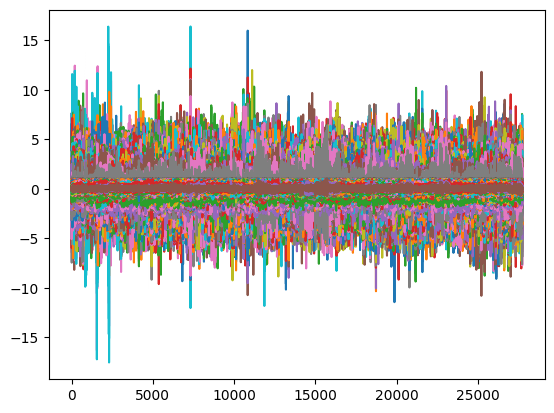

In [7]:

plt.plot(whole_region_norm_z.cpu().numpy())

print("----------------------------------------------------")

plt.plot(whole_region_norm_max.cpu().numpy())